# Prerequisites

Useful imports:

In [1]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from pathlib import Path
from interpretability.robustness import cos_similarity
from utils.symmetries import Symmetry
from typing import Dict, List, Any
from tqdm import tqdm
from utils.misc import set_random_seed


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sns.set_style("white")
set_random_seed(42)

/home/jonathan/anaconda3/envs/robustxai/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Define the scripts to quickly compute model invariance and feature importance equivariance:

In [2]:
# Compute model invariance and explanation equivariance for a given symmetry
def invariance_equivariance(
    x1: torch.Tensor,
    y: torch.Tensor,
    symmetry: Symmetry,
    model: torch.nn.Module,
    explainer: torch.nn.Module,
    similarity: callable = cos_similarity,
) -> Dict[str, Any]:
    x2 = symmetry(x1)
    y1 = model(x1)
    y2 = model(x2)
    e1 = explainer(x1, y)
    e2 = explainer(x2, y)
    result_dict = {"Model Invariance": torch.abs(similarity(y1, y2)).detach().cpu().item(),
                   "Explanation Equivariance": torch.abs(similarity(symmetry(e1), e2)).detach().cpu().item(),
                   "Symmetry": symmetry.parameters,
                   "x1": x1.detach().cpu(),
                   "x2": x2.detach().cpu(),
                   "y1": y1.detach().cpu(),
                   "y2": y2.detach().cpu(),
                   "e1": e1.detach().cpu(),
                   "e2": e2.detach().cpu(),
                   }
    return result_dict

# Scan different symmetries and compute invariance and equivariance
def compute_robustness(dataloader: DataLoader, 
                       device: torch.device, 
                       symmetry: Symmetry, 
                       model: torch.nn.Module,
                       explainer: torch.nn.Module):
    results = []
    for x, y in tqdm(dataloader, desc="Computing Robustness", unit="batch", leave=False):
        x, y = x.to(device), y.to(device)
        symmetry.sample_symmetry(x)
        result_dict = invariance_equivariance(x, y, symmetry, model, explainer)
        results.append(result_dict)
    return results

# Get the top-k least equivariance examples 
def get_topk_least_equivariance(results: List[Dict[str, Any]], k: int = 10) -> List[Dict[str, Any]]:
    equivariance = [result["Explanation Equivariance"] for result in results]
    topk = sorted(range(len(equivariance)), key=lambda i: equivariance[i])[:k]
    return [results[i] for i in topk]       

Define the useful scripts for plotting:

In [3]:
# Plot the images and explanations for the given examples
def plot_examples(examples: List[Dict[str, Any]], pil_transform: transforms, model_classes: List[str]) -> None:
    fig, axs = plt.subplots(len(examples), 4, figsize=(12, 3*len(examples)))
    for example_id, example in enumerate(examples):
        x1 = example["x1"]
        x2 = example["x2"]
        y1 = example["y1"]
        y2  = example["y2"]
        e1 =  example["e1"]
        e2 = example["e2"]
        x1 = pil_transform(x1.squeeze())
        x2 = pil_transform(x2.squeeze())
        e1 = torch.abs(e1).sum(dim=1).squeeze()
        e2 = torch.abs(e2).sum(dim=1).squeeze()
        y1 = model_classes[y1.argmax().item()].capitalize()
        y2 = model_classes[y2.argmax().item()].capitalize()
        invariance = example["Model Invariance"]
        equivariance = example["Explanation Equivariance"]
        symmetry = example["Symmetry"]
        axs[example_id, 0].imshow(x1)
        axs[example_id, 0].set_title(f"Predicted Class: {y1}")
        sns.heatmap(e1, ax=axs[example_id, 1], cbar=False)
        axs[example_id, 1].set_title(f"Original Saliency Map")
        axs[example_id, 2].imshow(x2)
        axs[example_id, 2].set_title(f"Predicted Class: {y2}")
        sns.heatmap(e2, ax=axs[example_id, 3], cbar=False)
        axs[example_id, 3].set_title(f"Transformed Saliency Map")
        plt.axis('off')
        
    for ax in axs.flat:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)    
        
        
        

# Failure Modes with FashionMNIST

In [4]:
from models.images import AllCNN 
from interpretability.feature import FeatureImportance
from captum.attr import GradientShap
from datasets.loaders import FashionMnistDataset
from utils.symmetries import Translation2D

Modify the bellow parameters freely:

In [5]:
model_path = Path.cwd() / "results/fashion_mnist/cnn32_seed42"
data_path = Path.cwd() / "datasets/fashion_mnist"
n_examples = 100
max_displacement = 10

Define model, explainer, symmetry group and the data:

In [6]:
# Load the model
model = AllCNN(32)
model.load_metadata(model_path)
model.load_state_dict(torch.load(model_path / "cnn32_seed42_allcnn.pt"))
model.eval().to(device)

# Load the explainer
attr_method = GradientShap(model)
explainer = FeatureImportance(attr_method)

# Load the symmetry group
symmetry = Translation2D(max_displacement=max_displacement)

# Load the data
dataset = FashionMnistDataset(data_path, train=False, max_displacement=max_displacement)
datasubset = Subset(dataset, range(n_examples))
data_loader = DataLoader(datasubset, batch_size=1)
print(f"Dataloader with {len(data_loader)} examples")

Dataloader with 100 examples


Compute the invariance and equivariance scores. Extract the top 5 worst failure modes for feature importance:

In [7]:
# Evaluate robustness
results_dict = compute_robustness(data_loader, device, symmetry, model, explainer)
top5 = get_topk_least_equivariance(results_dict, k=5)
print(f"Worst {len(top5)} examples equivariance: {[result['Explanation Equivariance'] for result in top5]}")
print(f"Worst {len(top5)} examples invariance: {[result['Model Invariance'] for result in top5]}")

Worst 5 examples equivariance: [0.058936234563589096, 0.08277733623981476, 0.17975176870822906, 0.1824086606502533, 0.21154718101024628]
Worst 5 examples invariance: [1.0000001192092896, 1.0, 1.0, 1.000000238418579, 1.0]


Display the top 5 worst failure modes for feature importance:

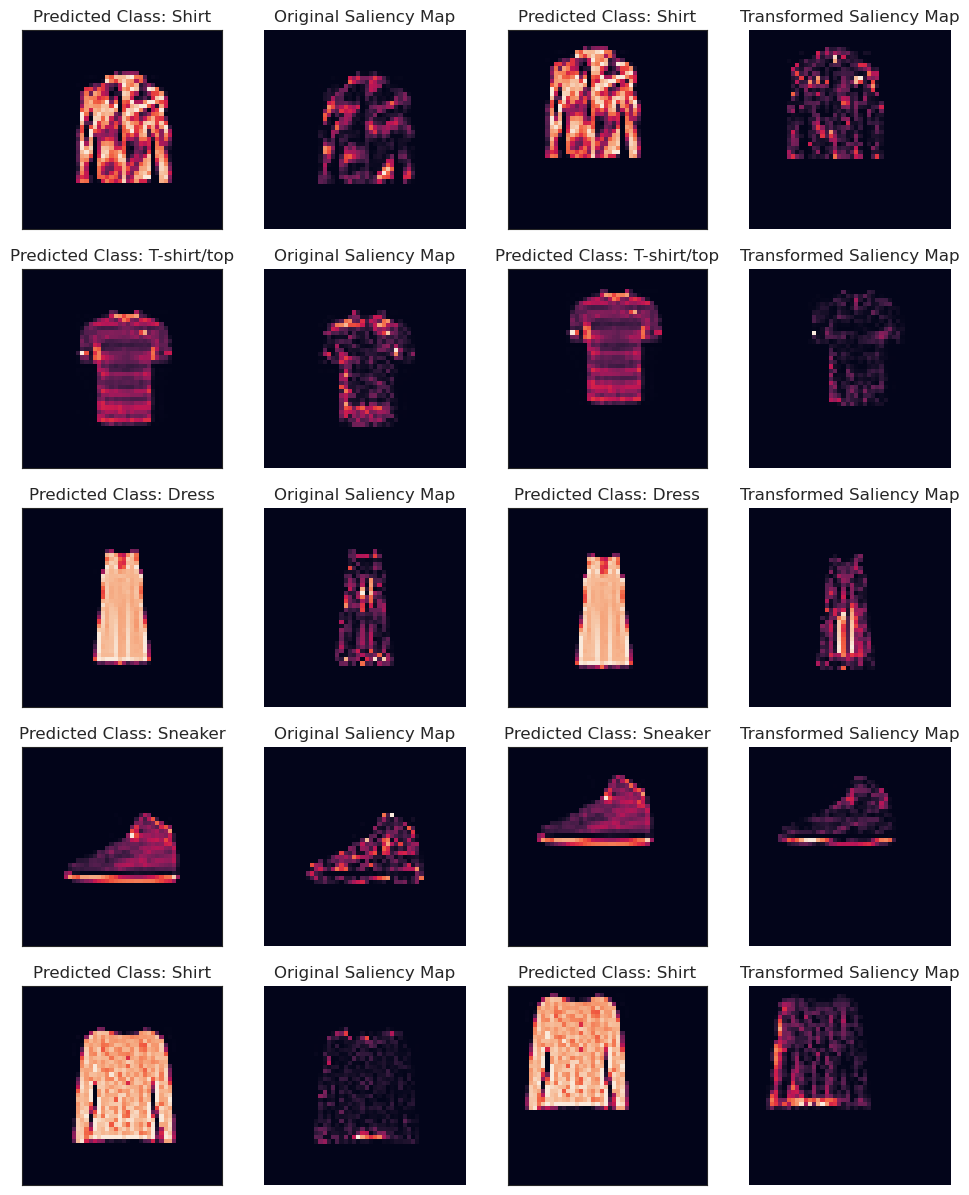

In [8]:
# Define conversion to PIL images
pil_transform = transforms.Compose([transforms.ToPILImage()])
dataset_classes = dataset.classes

# Plot the examples
plot_examples(top5, pil_transform, dataset_classes)

# Failure Modes with STL10

In [9]:
from models.images import Wide_ResNet 
from interpretability.feature import FeatureImportance
from captum.attr import DeepLift
from datasets.loaders import STL10Dataset
from utils.symmetries import Dihedral
from utils.misc import get_best_checkpoint

Modify the bellow parameters freely:

In [10]:
model_path = Path.cwd() / "results/stl10/stl10_d8_wideresnet_seed666"
data_path = Path.cwd() / "datasets/stl10"
n_examples = 100

Define model, explainer, symmetry group and the data:

In [11]:
# Load the model
checkpoint = torch.load(get_best_checkpoint(model_path))
model = Wide_ResNet(16, 8, initial_stride=2, num_classes=10)
model.load_state_dict(checkpoint["state_dict"], strict=False)
model.to(device).eval()

# Load the explainer
attr_method = DeepLift(model)
explainer = FeatureImportance(attr_method)

# Load the symmetry group
symmetry = Dihedral()

# Load the data
datamodule = STL10Dataset(data_path, batch_size=1, num_predict=n_examples)
datamodule.setup(stage="predict")
data_loader = datamodule.predict_dataloader()
print(f"Dataloader with {len(data_loader)} examples")

/home/jonathan/anaconda3/envs/robustxai/lib/python3.10/site-packages/e2cnn/nn/modules/r2_conv/basisexpansion_singleblock.py:80: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /opt/conda/conda-bld/pytorch_1666642969563/work/aten/src/ATen/native/IndexingUtils.h:27.)
  full_mask[mask] = norms.to(torch.uint8)
/home/jonathan/anaconda3/envs/robustxai/lib/python3.10/site-packages/e2cnn/nn/modules/r2_conv/basisexpansion_singleblock.py:80: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at /opt/conda/conda-bld/pytorch_1666642969563/work/aten/src/ATen/native/TensorAdvancedIndexing.cpp:1646.)
  full_mask[mask] = norms.to(torch.uint8)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Dataloader with 100 examples


Compute the invariance and equivariance scores. Extract the top 5 worst failure modes for feature importance:

In [12]:
# Evaluate robustness
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)
    results_dict = compute_robustness(data_loader, device, symmetry, model, explainer)
    top5 = get_topk_least_equivariance(results_dict, k=5)
    print(f"Worst {len(top5)} examples equivariance: {[result['Explanation Equivariance'] for result in top5]}")
    print(f"Worst {len(top5)} examples invariance: {[result['Model Invariance'] for result in top5]}")

Worst 5 examples equivariance: [0.6596119403839111, 0.6990478038787842, 0.7000929117202759, 0.7131022214889526, 0.715205729007721]
Worst 5 examples invariance: [0.997114896774292, 0.9990084767341614, 0.9930964708328247, 0.9945776462554932, 0.9963720440864563]


Display the top 5 worst failure modes for feature importance:

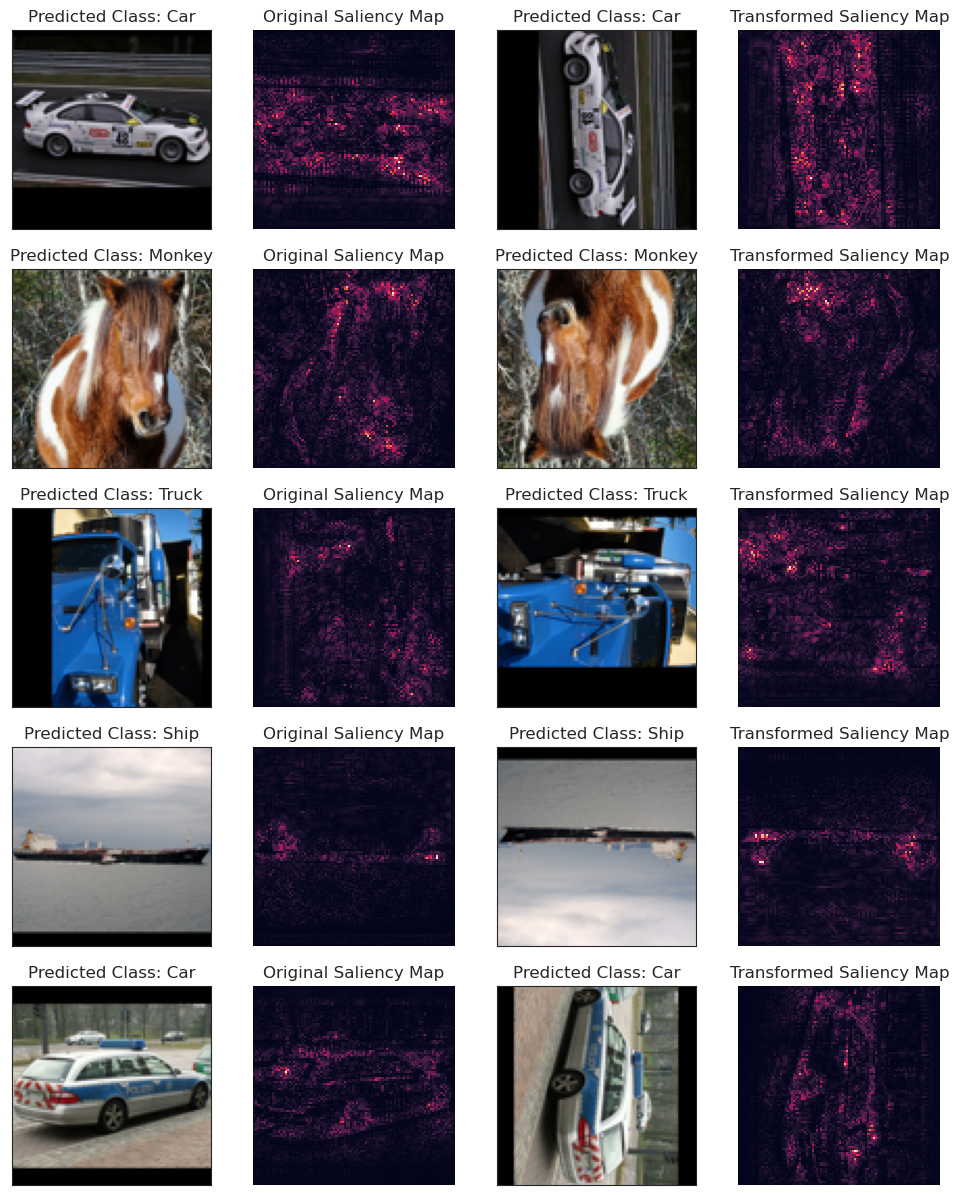

In [13]:
# Define conversion to PIL images
dataset_classes = datamodule.stl10_train.classes
mean = np.array([0.44508205, 0.43821473, 0.40541945])
std = np.array([0.26199411, 0.25827974, 0.27239384])
normalize = transforms.Normalize(
    mean=-mean/std,
    std=1/std,
)
pil_transform = transforms.Compose([normalize, transforms.ToPILImage()])
# Plot the examples
plot_examples(top5, pil_transform, dataset_classes)